In [ ]:
!pip install wandb

In [7]:
import wandb

In [8]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nipkha21 (nipkha21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import wandb
from tqdm import tqdm
import time
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
from data_utils import load_split_data
from models import SimpleCNN, get_model
from training_utils import ModelTrainer, get_optimizer, get_scheduler
from evaluation import ModelEvaluator

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class CNNFacialExpressionDataset(Dataset):
    def __init__(self, data, transform=None, augment=False, is_test=False):
        self.data = data
        self.transform = transform
        self.augment = augment
        self.is_test = is_test

        if transform is None:
            if augment and not is_test:
                self.transform = self._get_augmentation_transform()
            else:
                self.transform = self._get_basic_transform()

    def _get_basic_transform(self):
        return A.Compose([
            A.Normalize(mean=[0.485], std=[0.229]),
            ToTensorV2()
        ])

    def _get_augmentation_transform(self):
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=0),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            A.Blur(blur_limit=3, p=0.1),
            A.CoarseDropout(max_holes=1, max_height=8, max_width=8,
                           min_holes=1, min_height=4, min_width=4, p=0.2),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.3),
            A.Normalize(mean=[0.485], std=[0.229]),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        image = np.array([int(pixel) for pixel in pixels.split()]).reshape(48, 48)

        image = np.stack([image] * 3, axis=-1).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
            image = torch.FloatTensor(image).unsqueeze(0) / 255.0

        if self.is_test:
            return image
        else:
            emotion = int(self.data.iloc[idx]['emotion'])
            return image, emotion

In [ ]:
class ImprovedSimpleCNN(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3, use_batch_norm=True):
        super(ImprovedSimpleCNN, self).__init__()

        self.use_batch_norm = use_batch_norm

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if use_batch_norm else nn.Identity()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256) if use_batch_norm else nn.Identity()

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))

        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout_rate / 2)
        self.fc3 = nn.Linear(128, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if x.shape[1] == 3:
            x = x[:, 0:1, :, :]

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.adaptive_pool(x)

        x = x.view(-1, 256 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [6]:
class CNNTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer,
                 scheduler=None, device='cuda', experiment_name='experiment', run_name='run'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

        wandb.init(
            project="facial-expression-recognition",
            group=experiment_name,
            name=run_name,
            config={
                "data_split_method": "predefined_stratified",
                "train_samples": len(train_loader.dataset),
                "val_samples": len(val_loader.dataset),
                "split_random_state": 42
            },
            reinit=True
        )
        wandb.watch(self.model, log='all', log_freq=100)

        self.history = {
            'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
            'learning_rates': [], 'epoch_times': []
        }
        self.best_val_acc = 0.0
        self.best_model_state = None

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc="Training")
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(data)
            loss = self.criterion(outputs, targets)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for data, targets in tqdm(self.val_loader, desc="Validation"):
                data, targets = data.to(self.device), targets.to(self.device)

                outputs = self.model(data)
                loss = self.criterion(outputs, targets)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc, np.array(all_predictions), np.array(all_targets)

    def train(self, epochs, early_stopping_patience=10):
        print(f"Starting CNN training for {epochs} epochs...")

        patience_counter = 0

        for epoch in range(epochs):
            epoch_start = time.time()

            train_loss, train_acc = self.train_epoch()

            val_loss, val_acc, val_preds, val_targets = self.validate_epoch()

            current_lr = self.optimizer.param_groups[0]['lr']
            if self.scheduler:
                if isinstance(self.scheduler, ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_model_state = self.model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            epoch_time = time.time() - epoch_start

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(current_lr)
            self.history['epoch_times'].append(epoch_time)

            log_dict = {
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_acc,
                'val_loss': val_loss,
                'val_accuracy': val_acc,
                'learning_rate': current_lr,
                'epoch_time': epoch_time,
                'best_val_accuracy': self.best_val_acc
            }

            if (epoch + 1) % 15 == 0:
                emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
                log_dict['confusion_matrix'] = wandb.plot.confusion_matrix(
                    probs=None, y_true=val_targets, preds=val_preds,
                    class_names=list(emotion_map.values())
                )

            wandb.log(log_dict)

            print(f"Epoch {epoch+1}/{epochs}:")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"  LR: {current_lr:.6f}, Time: {epoch_time:.2f}s")
            print("-" * 50)

            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)
            print(f"Loaded best model with validation accuracy: {self.best_val_acc:.2f}%")

        return self.history

In [10]:
wandb.login()

print("=== LOADING PRE-SPLIT DATA ===")

train_df, val_df, test_df = load_split_data('drive/MyDrive/data')

emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

=== LOADING PRE-SPLIT DATA ===


In [ ]:
print("=== DATA AUGMENTATION EXPERIMENTS ===")

augmentation_strategies = {
    'no_augmentation': {
        'augment': False,
        'description': 'No data augmentation'
    },
    'advanced_augmentation': {
        'augment': True,
        'transform': A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, p=0.3),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            A.Normalize(mean=[0.485], std=[0.229]),
            ToTensorV2()
        ]),
        'description': 'Advanced: Flip + Rotation + Brightness + Noise'
    },
    'heavy_augmentation': {
        'augment': True,
        'transform': A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=20, p=0.4),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.4),
            A.GaussNoise(var_limit=(10.0, 80.0), p=0.3),
            A.Blur(blur_limit=3, p=0.2),
            A.CoarseDropout(max_holes=2, max_height=8, max_width=8, p=0.3),
            A.Normalize(mean=[0.485], std=[0.229]),
            ToTensorV2()
        ]),
        'description': 'Heavy: All augmentations'
    }
}

=== DATA AUGMENTATION EXPERIMENTS ===


<ipython-input-14-f54979933ea5>:14: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
<ipython-input-14-f54979933ea5>:26: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.3),
<ipython-input-14-f54979933ea5>:28: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=2, max_height=8, max_width=8, p=0.3),


In [ ]:
augmentation_results = {}

for aug_name, aug_config in augmentation_strategies.items():
    print(f"\nTesting augmentation strategy: {aug_name}")
    print(f"Description: {aug_config['description']}")

    if 'transform' in aug_config:
        train_dataset = CNNFacialExpressionDataset(
            train_df, transform=aug_config['transform'], augment=False
        )
        val_dataset = CNNFacialExpressionDataset(
            val_df, transform=A.Compose([
                A.Normalize(mean=[0.485], std=[0.229]),
                ToTensorV2()
            ]), augment=False
        )
    else:
        train_dataset = CNNFacialExpressionDataset(
            train_df, augment=aug_config['augment']
        )
        val_dataset = CNNFacialExpressionDataset(
            val_df, augment=False
        )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = SimpleCNN(num_classes=7, dropout_rate=0.5)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trainer = CNNTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        experiment_name="Simple_CNN_Training",
        run_name=f"Augmentation_{aug_name}"
    )

    history = trainer.train(epochs=10, early_stopping_patience=5)

    augmentation_results[aug_name] = {
        'best_val_acc': trainer.best_val_acc,
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'overfitting_score': history['train_acc'][-1] - history['val_acc'][-1]
    }

    wandb.finish()

    print(f"Best validation accuracy: {trainer.best_val_acc:.2f}%")

print("\n=== AUGMENTATION ANALYSIS ===")
best_augmentation = max(augmentation_results.keys(),
                       key=lambda x: augmentation_results[x]['best_val_acc'])
print(f"Best augmentation strategy: {best_augmentation}")

for aug_name, results in augmentation_results.items():
    print(f"{aug_name}: {results['best_val_acc']:.2f}% "
          f"(overfitting: {results['overfitting_score']:.2f}%)")


Testing augmentation strategy: no_augmentation
Description: No data augmentation


Starting CNN training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.53it/s]


Epoch 1/10:
  Train Loss: 1.6176, Train Acc: 36.10%
  Val Loss: 1.4359, Val Acc: 46.34%
  LR: 0.001000, Time: 10.08s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 39.06it/s]


Epoch 2/10:
  Train Loss: 1.3601, Train Acc: 48.69%
  Val Loss: 1.2763, Val Acc: 51.43%
  LR: 0.001000, Time: 9.86s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.91it/s]


Epoch 3/10:
  Train Loss: 1.2343, Train Acc: 53.61%
  Val Loss: 1.2149, Val Acc: 53.68%
  LR: 0.001000, Time: 10.05s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.55it/s]


Epoch 4/10:
  Train Loss: 1.1259, Train Acc: 57.91%
  Val Loss: 1.1877, Val Acc: 55.42%
  LR: 0.001000, Time: 10.12s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.44it/s]


Epoch 5/10:
  Train Loss: 1.0266, Train Acc: 61.62%
  Val Loss: 1.1715, Val Acc: 55.28%
  LR: 0.001000, Time: 10.01s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.95it/s]


Epoch 6/10:
  Train Loss: 0.9214, Train Acc: 65.84%
  Val Loss: 1.1799, Val Acc: 57.26%
  LR: 0.001000, Time: 9.93s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.75it/s]


Epoch 7/10:
  Train Loss: 0.7979, Train Acc: 70.93%
  Val Loss: 1.2636, Val Acc: 56.63%
  LR: 0.001000, Time: 10.01s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.86it/s]


Epoch 8/10:
  Train Loss: 0.6853, Train Acc: 74.94%
  Val Loss: 1.2472, Val Acc: 57.39%
  LR: 0.001000, Time: 9.92s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.33it/s]


Epoch 9/10:
  Train Loss: 0.5713, Train Acc: 79.10%
  Val Loss: 1.3776, Val Acc: 57.05%
  LR: 0.001000, Time: 10.00s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.95it/s]

Epoch 10/10:
  Train Loss: 0.4782, Train Acc: 82.65%
  Val Loss: 1.4417, Val Acc: 57.26%
  LR: 0.001000, Time: 10.04s
--------------------------------------------------
Loaded best model with validation accuracy: 57.39%


best_val_accuracy,▁▄▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▇▁▆█▅▃▅▃▅▆
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▆▇▇█
train_loss,█▆▆▅▄▄▃▂▂▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▄▂▁▁▁▃▃▆█
best_val_accuracy,57.39494
epoch,10
epoch_time,10.04247


Best validation accuracy: 57.39%

Testing augmentation strategy: advanced_augmentation
Description: Advanced: Flip + Rotation + Brightness + Noise


Starting CNN training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.16it/s]


Epoch 1/10:
  Train Loss: 1.7152, Train Acc: 31.03%
  Val Loss: 1.5393, Val Acc: 40.96%
  LR: 0.001000, Time: 12.20s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.72it/s]


Epoch 2/10:
  Train Loss: 1.5369, Train Acc: 40.30%
  Val Loss: 1.4121, Val Acc: 45.25%
  LR: 0.001000, Time: 11.90s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 27.26it/s]


Epoch 3/10:
  Train Loss: 1.4461, Train Acc: 44.10%
  Val Loss: 1.3187, Val Acc: 49.38%
  LR: 0.001000, Time: 13.73s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 29.56it/s]


Epoch 4/10:
  Train Loss: 1.3935, Train Acc: 46.29%
  Val Loss: 1.2625, Val Acc: 51.89%
  LR: 0.001000, Time: 13.50s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.71it/s]


Epoch 5/10:
  Train Loss: 1.3516, Train Acc: 48.18%
  Val Loss: 1.2359, Val Acc: 52.59%
  LR: 0.001000, Time: 13.02s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.18it/s]


Epoch 6/10:
  Train Loss: 1.3160, Train Acc: 49.36%
  Val Loss: 1.1980, Val Acc: 54.21%
  LR: 0.001000, Time: 12.35s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.72it/s]


Epoch 7/10:
  Train Loss: 1.2856, Train Acc: 50.44%
  Val Loss: 1.1921, Val Acc: 54.49%
  LR: 0.001000, Time: 12.40s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.36it/s]


Epoch 8/10:
  Train Loss: 1.2623, Train Acc: 51.54%
  Val Loss: 1.1609, Val Acc: 55.61%
  LR: 0.001000, Time: 12.51s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.89it/s]


Epoch 9/10:
  Train Loss: 1.2392, Train Acc: 52.62%
  Val Loss: 1.1396, Val Acc: 56.58%
  LR: 0.001000, Time: 12.34s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.10it/s]

Epoch 10/10:
  Train Loss: 1.2175, Train Acc: 53.52%
  Val Loss: 1.1418, Val Acc: 56.51%
  LR: 0.001000, Time: 12.46s
--------------------------------------------------
Loaded best model with validation accuracy: 56.58%


best_val_accuracy,▁▃▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▂▁█▇▅▃▃▃▃▃
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
best_val_accuracy,56.58231
epoch,10
epoch_time,12.46165


Best validation accuracy: 56.58%

Testing augmentation strategy: heavy_augmentation
Description: Heavy: All augmentations


Starting CNN training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.03it/s]


Epoch 1/10:
  Train Loss: 1.7745, Train Acc: 27.21%
  Val Loss: 1.6387, Val Acc: 33.97%
  LR: 0.001000, Time: 13.64s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.89it/s]


Epoch 2/10:
  Train Loss: 1.6500, Train Acc: 34.72%
  Val Loss: 1.5179, Val Acc: 41.33%
  LR: 0.001000, Time: 13.72s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.80it/s]


Epoch 3/10:
  Train Loss: 1.5702, Train Acc: 39.13%
  Val Loss: 1.4114, Val Acc: 45.90%
  LR: 0.001000, Time: 13.49s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.87it/s]


Epoch 4/10:
  Train Loss: 1.5253, Train Acc: 40.36%
  Val Loss: 1.3675, Val Acc: 47.92%
  LR: 0.001000, Time: 13.45s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.28it/s]


Epoch 5/10:
  Train Loss: 1.4864, Train Acc: 42.19%
  Val Loss: 1.3090, Val Acc: 49.50%
  LR: 0.001000, Time: 13.76s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.80it/s]


Epoch 6/10:
  Train Loss: 1.4509, Train Acc: 43.64%
  Val Loss: 1.2887, Val Acc: 51.22%
  LR: 0.001000, Time: 13.51s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.78it/s]


Epoch 7/10:
  Train Loss: 1.4302, Train Acc: 44.62%
  Val Loss: 1.2745, Val Acc: 51.75%
  LR: 0.001000, Time: 13.38s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.94it/s]


Epoch 8/10:
  Train Loss: 1.4199, Train Acc: 45.13%
  Val Loss: 1.2262, Val Acc: 53.49%
  LR: 0.001000, Time: 13.44s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.74it/s]


Epoch 9/10:
  Train Loss: 1.3969, Train Acc: 45.96%
  Val Loss: 1.2073, Val Acc: 54.21%
  LR: 0.001000, Time: 13.65s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.18it/s]

Epoch 10/10:
  Train Loss: 1.3797, Train Acc: 46.70%
  Val Loss: 1.1938, Val Acc: 54.24%
  LR: 0.001000, Time: 13.59s
--------------------------------------------------
Loaded best model with validation accuracy: 54.24%


best_val_accuracy,▁▄▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▆▇▃▂█▄▁▂▆▅
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▆▄▄▃▂▂▂▁▁
best_val_accuracy,54.23729
epoch,10
epoch_time,13.59474


Best validation accuracy: 54.24%

=== AUGMENTATION ANALYSIS ===
Best augmentation strategy: no_augmentation
no_augmentation: 57.39% (overfitting: 25.39%)
advanced_augmentation: 56.58% (overfitting: -3.00%)
heavy_augmentation: 54.24% (overfitting: -7.53%)


In [ ]:
best_augmentation = 'advanced_augmentation' # no_augmentations jobia mainc overfittingis gamo

In [ ]:
print("=== CNN ARCHITECTURE COMPARISON ===")

architectures = {
    'simple_cnn_low_dropout': {
        'model': SimpleCNN(num_classes=7, dropout_rate=0.3),
        'description': 'Basic CNN with lower dropout'
    },
    'improved_cnn': {
        'model': ImprovedSimpleCNN(num_classes=7, dropout_rate=0.3, use_batch_norm=True),
        'description': 'Improved CNN with BatchNorm'
    },
}

architecture_results = {}

best_aug_config = augmentation_strategies[best_augmentation]

for arch_name, arch_config in architectures.items():
    print(f"\nTesting architecture: {arch_name}")
    print(f"Description: {arch_config['description']}")

    if 'transform' in best_aug_config:
        train_dataset = CNNFacialExpressionDataset(
            train_df, transform=best_aug_config['transform'], augment=False
        )
        val_dataset = CNNFacialExpressionDataset(
            val_df, transform=A.Compose([
                A.Normalize(mean=[0.485], std=[0.229]),
                ToTensorV2()
            ]), augment=False
        )
    else:
        train_dataset = CNNFacialExpressionDataset(
            train_df, augment=best_aug_config['augment']
        )
        val_dataset = CNNFacialExpressionDataset(
            val_df, augment=False
        )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = arch_config['model']

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    trainer = CNNTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        experiment_name="Simple_CNN_Training",
        run_name=f"Architecture_{arch_name}"
    )

    history = trainer.train(epochs=10, early_stopping_patience=7)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    architecture_results[arch_name] = {
        'best_val_acc': trainer.best_val_acc,
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'total_params': total_params,
        'trainable_params': trainable_params,
        'avg_epoch_time': np.mean(history['epoch_times'])
    }

    wandb.finish()

    print(f"Best validation accuracy: {trainer.best_val_acc:.2f}%")
    print(f"Total parameters: {total_params:,}")

print("\n=== ARCHITECTURE ANALYSIS ===")
best_architecture = max(architecture_results.keys(),
                       key=lambda x: architecture_results[x]['best_val_acc'])
print(f"Best architecture: {best_architecture}")

for arch_name, results in architecture_results.items():
    print(f"{arch_name}: {results['best_val_acc']:.2f}% "
          f"({results['total_params']:,} params, "
          f"{results['avg_epoch_time']:.2f}s/epoch)")

=== CNN ARCHITECTURE COMPARISON ===

Testing architecture: simple_cnn_low_dropout
Description: Basic CNN with lower dropout


Starting CNN training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.06it/s]


Epoch 1/10:
  Train Loss: 1.6835, Train Acc: 32.99%
  Val Loss: 1.4946, Val Acc: 41.72%
  LR: 0.001000, Time: 12.19s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.34it/s]


Epoch 2/10:
  Train Loss: 1.4986, Train Acc: 41.99%
  Val Loss: 1.3843, Val Acc: 47.46%
  LR: 0.001000, Time: 12.44s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.10it/s]


Epoch 3/10:
  Train Loss: 1.4143, Train Acc: 45.34%
  Val Loss: 1.2958, Val Acc: 50.71%
  LR: 0.001000, Time: 12.43s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.53it/s]


Epoch 4/10:
  Train Loss: 1.3496, Train Acc: 48.00%
  Val Loss: 1.2250, Val Acc: 53.96%
  LR: 0.001000, Time: 12.29s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.51it/s]


Epoch 5/10:
  Train Loss: 1.3082, Train Acc: 49.56%
  Val Loss: 1.2150, Val Acc: 52.96%
  LR: 0.001000, Time: 12.28s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.75it/s]


Epoch 6/10:
  Train Loss: 1.2731, Train Acc: 51.16%
  Val Loss: 1.1711, Val Acc: 56.21%
  LR: 0.001000, Time: 12.15s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.43it/s]


Epoch 7/10:
  Train Loss: 1.2424, Train Acc: 52.64%
  Val Loss: 1.1472, Val Acc: 56.33%
  LR: 0.001000, Time: 12.10s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.85it/s]


Epoch 8/10:
  Train Loss: 1.2150, Train Acc: 53.30%
  Val Loss: 1.1399, Val Acc: 56.88%
  LR: 0.001000, Time: 12.40s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.42it/s]


Epoch 9/10:
  Train Loss: 1.1836, Train Acc: 54.96%
  Val Loss: 1.1243, Val Acc: 57.49%
  LR: 0.001000, Time: 12.09s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.03it/s]

Epoch 10/10:
  Train Loss: 1.1679, Train Acc: 55.32%
  Val Loss: 1.1129, Val Acc: 58.35%
  LR: 0.001000, Time: 12.17s
--------------------------------------------------
Loaded best model with validation accuracy: 58.35%


best_val_accuracy,▁▃▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▃██▅▅▂▁▇▁▃
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
best_val_accuracy,58.34688
epoch,10
epoch_time,12.17192


Best validation accuracy: 58.35%
Total parameters: 2,456,071

Testing architecture: improved_cnn
Description: Improved CNN with BatchNorm


Starting CNN training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.16it/s]


Epoch 1/10:
  Train Loss: 1.8728, Train Acc: 23.37%
  Val Loss: 1.7814, Val Acc: 28.12%
  LR: 0.001000, Time: 12.34s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.30it/s]


Epoch 2/10:
  Train Loss: 1.6862, Train Acc: 31.42%
  Val Loss: 1.5131, Val Acc: 39.35%
  LR: 0.001000, Time: 12.05s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.25it/s]


Epoch 3/10:
  Train Loss: 1.5650, Train Acc: 37.95%
  Val Loss: 1.4250, Val Acc: 43.79%
  LR: 0.001000, Time: 11.97s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.12it/s]


Epoch 4/10:
  Train Loss: 1.4877, Train Acc: 42.02%
  Val Loss: 1.3256, Val Acc: 48.20%
  LR: 0.001000, Time: 11.88s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.08it/s]


Epoch 5/10:
  Train Loss: 1.4280, Train Acc: 44.40%
  Val Loss: 1.2852, Val Acc: 51.01%
  LR: 0.001000, Time: 12.10s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.78it/s]


Epoch 6/10:
  Train Loss: 1.3910, Train Acc: 45.86%
  Val Loss: 1.2568, Val Acc: 51.87%
  LR: 0.001000, Time: 12.27s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.74it/s]


Epoch 7/10:
  Train Loss: 1.3653, Train Acc: 46.99%
  Val Loss: 1.2195, Val Acc: 53.73%
  LR: 0.001000, Time: 12.01s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.78it/s]


Epoch 8/10:
  Train Loss: 1.3307, Train Acc: 48.88%
  Val Loss: 1.1929, Val Acc: 53.91%
  LR: 0.001000, Time: 11.99s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.78it/s]


Epoch 9/10:
  Train Loss: 1.3030, Train Acc: 50.00%
  Val Loss: 1.1994, Val Acc: 54.82%
  LR: 0.001000, Time: 12.09s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.14it/s]

Epoch 10/10:
  Train Loss: 1.2855, Train Acc: 50.71%
  Val Loss: 1.1798, Val Acc: 53.66%
  LR: 0.001000, Time: 12.09s
--------------------------------------------------
Loaded best model with validation accuracy: 54.82%


best_val_accuracy,▁▄▅▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,█▄▂▁▄▇▃▃▄▄
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▅▆▆▇▇███
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
best_val_accuracy,54.81774
epoch,10
epoch_time,12.08908


Best validation accuracy: 54.82%
Total parameters: 1,635,527

=== ARCHITECTURE ANALYSIS ===
Best architecture: simple_cnn_low_dropout
simple_cnn_low_dropout: 58.35% (2,456,071 params, 12.25s/epoch)
improved_cnn: 54.82% (1,635,527 params, 12.08s/epoch)


In [ ]:
print("=== KERNEL SIZE AND FILTER EXPERIMENTS ===")

class FlexibleCNN(nn.Module):

    def __init__(self, kernel_sizes=[3, 3, 3], num_filters=[32, 64, 128],
                 num_classes=7, dropout_rate=0.3):
        super(FlexibleCNN, self).__init__()

        paddings = [k//2 for k in kernel_sizes]

        self.conv1 = nn.Conv2d(1, num_filters[0], kernel_size=kernel_sizes[0], padding=paddings[0])
        self.bn1 = nn.BatchNorm2d(num_filters[0])

        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=kernel_sizes[1], padding=paddings[1])
        self.bn2 = nn.BatchNorm2d(num_filters[1])

        self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=kernel_sizes[2], padding=paddings[2])
        self.bn3 = nn.BatchNorm2d(num_filters[2])

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))

        self.fc1 = nn.Linear(num_filters[2] * 3 * 3, 512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if x.shape[1] == 3:
            x = x[:, 0:1, :, :]

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = self.adaptive_pool(x)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

cnn_configs = [
    {'kernel_sizes': [3, 3, 3], 'num_filters': [32, 64, 128], 'name': 'baseline'},
    {'kernel_sizes': [5, 3, 3], 'num_filters': [32, 64, 128], 'name': 'large_first_kernel'},
    {'kernel_sizes': [3, 3, 3], 'num_filters': [64, 128, 256], 'name': 'more_filters'},
    {'kernel_sizes': [7, 5, 3], 'num_filters': [32, 64, 128], 'name': 'decreasing_kernels'},
    {'kernel_sizes': [3, 3, 3], 'num_filters': [16, 32, 64], 'name': 'fewer_filters'}
]

config_results = {}

for config in cnn_configs:
    print(f"\nTesting CNN configuration: {config['name']}")

    if 'transform' in best_aug_config:
        train_dataset = CNNFacialExpressionDataset(
            train_df, transform=best_aug_config['transform'], augment=False
        )
        val_dataset = CNNFacialExpressionDataset(
            val_df, transform=A.Compose([
                A.Normalize(mean=[0.485], std=[0.229]),
                ToTensorV2()
            ]), augment=False
        )
    else:
        train_dataset = CNNFacialExpressionDataset(
            train_df, augment=best_aug_config['augment']
        )
        val_dataset = CNNFacialExpressionDataset(
            val_df, augment=False
        )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = FlexibleCNN(
        kernel_sizes=config['kernel_sizes'],
        num_filters=config['num_filters'],
        num_classes=7,
        dropout_rate=0.3
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trainer = CNNTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        experiment_name="Simple_CNN_Training",
        run_name=f"Config_{config['name']}"
    )

    history = trainer.train(epochs=10, early_stopping_patience=6)

    config_results[config['name']] = {
        'best_val_acc': trainer.best_val_acc,
        'config': config,
        'total_params': sum(p.numel() for p in model.parameters())
    }

    wandb.finish()

print("\n=== CONFIGURATION ANALYSIS ===")
for config_name, results in config_results.items():
    print(f"{config_name}: {results['best_val_acc']:.2f}% "
          f"({results['total_params']:,} params)")

=== KERNEL SIZE AND FILTER EXPERIMENTS ===

Testing CNN configuration: baseline


Starting CNN training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.70it/s]


Epoch 1/10:
  Train Loss: 1.8274, Train Acc: 25.45%
  Val Loss: 1.6824, Val Acc: 29.56%
  LR: 0.001000, Time: 12.13s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.38it/s]


Epoch 2/10:
  Train Loss: 1.6536, Train Acc: 33.99%
  Val Loss: 1.5095, Val Acc: 41.12%
  LR: 0.001000, Time: 11.99s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.39it/s]


Epoch 3/10:
  Train Loss: 1.5765, Train Acc: 37.66%
  Val Loss: 1.4406, Val Acc: 45.25%
  LR: 0.001000, Time: 12.30s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.41it/s]


Epoch 4/10:
  Train Loss: 1.5375, Train Acc: 39.68%
  Val Loss: 1.4294, Val Acc: 44.25%
  LR: 0.001000, Time: 11.95s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.05it/s]


Epoch 5/10:
  Train Loss: 1.5024, Train Acc: 40.87%
  Val Loss: 1.3710, Val Acc: 47.43%
  LR: 0.001000, Time: 11.89s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.58it/s]


Epoch 6/10:
  Train Loss: 1.4786, Train Acc: 42.35%
  Val Loss: 1.3283, Val Acc: 50.03%
  LR: 0.001000, Time: 12.07s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.68it/s]


Epoch 7/10:
  Train Loss: 1.4540, Train Acc: 43.38%
  Val Loss: 1.2931, Val Acc: 49.83%
  LR: 0.001000, Time: 11.99s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.93it/s]


Epoch 8/10:
  Train Loss: 1.4346, Train Acc: 44.31%
  Val Loss: 1.3068, Val Acc: 49.90%
  LR: 0.001000, Time: 11.90s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.87it/s]


Epoch 9/10:
  Train Loss: 1.4203, Train Acc: 44.67%
  Val Loss: 1.2775, Val Acc: 51.08%
  LR: 0.001000, Time: 12.01s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.72it/s]

Epoch 10/10:
  Train Loss: 1.4038, Train Acc: 45.63%
  Val Loss: 1.2631, Val Acc: 51.94%
  LR: 0.001000, Time: 11.98s
--------------------------------------------------
Loaded best model with validation accuracy: 51.94%


best_val_accuracy,▁▅▆▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▅▃█▂▁▄▃▁▃▂
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▆▆▇▇▇▇██
val_loss,█▅▄▄▃▂▂▂▁▁
best_val_accuracy,51.9387
epoch,10
epoch_time,11.97788



Testing CNN configuration: large_first_kernel


Starting CNN training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.96it/s]


Epoch 1/10:
  Train Loss: 1.8345, Train Acc: 25.57%
  Val Loss: 1.6854, Val Acc: 30.23%
  LR: 0.001000, Time: 11.98s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.72it/s]


Epoch 2/10:
  Train Loss: 1.6565, Train Acc: 33.63%
  Val Loss: 1.5319, Val Acc: 41.93%
  LR: 0.001000, Time: 12.15s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.86it/s]


Epoch 3/10:
  Train Loss: 1.5646, Train Acc: 38.75%
  Val Loss: 1.4479, Val Acc: 44.49%
  LR: 0.001000, Time: 12.04s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.57it/s]


Epoch 4/10:
  Train Loss: 1.5112, Train Acc: 41.11%
  Val Loss: 1.3920, Val Acc: 47.13%
  LR: 0.001000, Time: 12.04s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.95it/s]


Epoch 5/10:
  Train Loss: 1.4831, Train Acc: 42.47%
  Val Loss: 1.3599, Val Acc: 47.74%
  LR: 0.001000, Time: 12.03s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.63it/s]


Epoch 6/10:
  Train Loss: 1.4499, Train Acc: 43.77%
  Val Loss: 1.3123, Val Acc: 50.08%
  LR: 0.001000, Time: 12.08s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.81it/s]


Epoch 7/10:
  Train Loss: 1.4303, Train Acc: 44.53%
  Val Loss: 1.3127, Val Acc: 48.90%
  LR: 0.001000, Time: 12.24s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.92it/s]


Epoch 8/10:
  Train Loss: 1.4082, Train Acc: 45.97%
  Val Loss: 1.2784, Val Acc: 50.80%
  LR: 0.001000, Time: 12.04s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.22it/s]


Epoch 9/10:
  Train Loss: 1.3906, Train Acc: 46.26%
  Val Loss: 1.2568, Val Acc: 51.13%
  LR: 0.001000, Time: 12.03s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.64it/s]

Epoch 10/10:
  Train Loss: 1.3704, Train Acc: 47.01%
  Val Loss: 1.2604, Val Acc: 51.20%
  LR: 0.001000, Time: 12.11s
--------------------------------------------------
Loaded best model with validation accuracy: 51.20%


best_val_accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▁▆▂▂▂▄█▃▂▅
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▆▇▇█▇███
val_loss,█▅▄▃▃▂▂▁▁▁
best_val_accuracy,51.19573
epoch,10
epoch_time,12.11134



Testing CNN configuration: more_filters


Starting CNN training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.92it/s]


Epoch 1/10:
  Train Loss: 1.8945, Train Acc: 24.54%
  Val Loss: 1.7082, Val Acc: 29.07%
  LR: 0.001000, Time: 12.10s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.21it/s]


Epoch 2/10:
  Train Loss: 1.6885, Train Acc: 31.34%
  Val Loss: 1.5517, Val Acc: 38.98%
  LR: 0.001000, Time: 12.15s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.70it/s]


Epoch 3/10:
  Train Loss: 1.6055, Train Acc: 35.71%
  Val Loss: 1.4925, Val Acc: 42.63%
  LR: 0.001000, Time: 12.03s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.03it/s]


Epoch 4/10:
  Train Loss: 1.5650, Train Acc: 37.58%
  Val Loss: 1.4391, Val Acc: 43.49%
  LR: 0.001000, Time: 12.09s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.52it/s]


Epoch 5/10:
  Train Loss: 1.5450, Train Acc: 38.41%
  Val Loss: 1.3958, Val Acc: 46.23%
  LR: 0.001000, Time: 12.13s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.94it/s]


Epoch 6/10:
  Train Loss: 1.5181, Train Acc: 39.67%
  Val Loss: 1.3769, Val Acc: 45.72%
  LR: 0.001000, Time: 12.05s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.09it/s]


Epoch 7/10:
  Train Loss: 1.4927, Train Acc: 41.00%
  Val Loss: 1.3549, Val Acc: 47.36%
  LR: 0.001000, Time: 11.95s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.90it/s]


Epoch 8/10:
  Train Loss: 1.4797, Train Acc: 41.41%
  Val Loss: 1.3035, Val Acc: 50.68%
  LR: 0.001000, Time: 11.97s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.04it/s]


Epoch 9/10:
  Train Loss: 1.4630, Train Acc: 42.08%
  Val Loss: 1.3135, Val Acc: 48.76%
  LR: 0.001000, Time: 12.01s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.10it/s]

Epoch 10/10:
  Train Loss: 1.4526, Train Acc: 42.99%
  Val Loss: 1.2836, Val Acc: 50.57%
  LR: 0.001000, Time: 11.95s
--------------------------------------------------
Loaded best model with validation accuracy: 50.68%


best_val_accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▆█▄▆▇▄▁▂▃▁
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▆▇█▇█
val_loss,█▅▄▄▃▃▂▁▁▁
best_val_accuracy,50.68493
epoch,10
epoch_time,11.94995



Testing CNN configuration: decreasing_kernels


Starting CNN training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.50it/s]


Epoch 1/10:
  Train Loss: 1.8226, Train Acc: 26.71%
  Val Loss: 1.6839, Val Acc: 32.88%
  LR: 0.001000, Time: 12.13s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.91it/s]


Epoch 2/10:
  Train Loss: 1.6585, Train Acc: 34.29%
  Val Loss: 1.5639, Val Acc: 38.61%
  LR: 0.001000, Time: 12.12s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.07it/s]


Epoch 3/10:
  Train Loss: 1.5629, Train Acc: 38.74%
  Val Loss: 1.4428, Val Acc: 44.21%
  LR: 0.001000, Time: 11.99s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.08it/s]


Epoch 4/10:
  Train Loss: 1.5147, Train Acc: 40.56%
  Val Loss: 1.4128, Val Acc: 44.93%
  LR: 0.001000, Time: 12.07s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.94it/s]


Epoch 5/10:
  Train Loss: 1.4755, Train Acc: 42.89%
  Val Loss: 1.3500, Val Acc: 48.25%
  LR: 0.001000, Time: 12.13s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.28it/s]


Epoch 6/10:
  Train Loss: 1.4492, Train Acc: 44.11%
  Val Loss: 1.3343, Val Acc: 47.55%
  LR: 0.001000, Time: 12.13s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.47it/s]


Epoch 7/10:
  Train Loss: 1.4265, Train Acc: 44.78%
  Val Loss: 1.2946, Val Acc: 49.15%
  LR: 0.001000, Time: 12.00s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.54it/s]


Epoch 8/10:
  Train Loss: 1.3990, Train Acc: 45.72%
  Val Loss: 1.3117, Val Acc: 48.01%
  LR: 0.001000, Time: 12.25s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.44it/s]


Epoch 9/10:
  Train Loss: 1.3918, Train Acc: 46.03%
  Val Loss: 1.2515, Val Acc: 51.75%
  LR: 0.001000, Time: 12.05s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.33it/s]

Epoch 10/10:
  Train Loss: 1.3663, Train Acc: 47.59%
  Val Loss: 1.2518, Val Acc: 51.20%
  LR: 0.001000, Time: 12.07s
--------------------------------------------------
Loaded best model with validation accuracy: 51.75%


best_val_accuracy,▁▃▅▅▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▅▄▁▃▅▅▁█▃▃
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▇▇▇▇█
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▅▇▆▇▇██
val_loss,█▆▄▄▃▂▂▂▁▁
best_val_accuracy,51.75296
epoch,10
epoch_time,12.06876



Testing CNN configuration: fewer_filters


Starting CNN training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.88it/s]


Epoch 1/10:
  Train Loss: 1.7931, Train Acc: 27.39%
  Val Loss: 1.6304, Val Acc: 35.87%
  LR: 0.001000, Time: 12.24s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.12it/s]


Epoch 2/10:
  Train Loss: 1.6343, Train Acc: 35.20%
  Val Loss: 1.5180, Val Acc: 38.89%
  LR: 0.001000, Time: 11.91s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.23it/s]


Epoch 3/10:
  Train Loss: 1.5595, Train Acc: 38.93%
  Val Loss: 1.4343, Val Acc: 43.58%
  LR: 0.001000, Time: 11.99s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.81it/s]


Epoch 4/10:
  Train Loss: 1.5065, Train Acc: 41.26%
  Val Loss: 1.4319, Val Acc: 44.72%
  LR: 0.001000, Time: 12.06s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.24it/s]


Epoch 5/10:
  Train Loss: 1.4741, Train Acc: 42.52%
  Val Loss: 1.3722, Val Acc: 46.09%
  LR: 0.001000, Time: 11.97s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.57it/s]


Epoch 6/10:
  Train Loss: 1.4484, Train Acc: 43.57%
  Val Loss: 1.3220, Val Acc: 49.34%
  LR: 0.001000, Time: 12.09s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.16it/s]


Epoch 7/10:
  Train Loss: 1.4303, Train Acc: 44.76%
  Val Loss: 1.3721, Val Acc: 46.85%
  LR: 0.001000, Time: 12.25s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.33it/s]


Epoch 8/10:
  Train Loss: 1.4119, Train Acc: 45.29%
  Val Loss: 1.2678, Val Acc: 51.34%
  LR: 0.001000, Time: 12.01s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.23it/s]


Epoch 9/10:
  Train Loss: 1.3842, Train Acc: 46.61%
  Val Loss: 1.2469, Val Acc: 52.40%
  LR: 0.001000, Time: 12.07s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.43it/s]

Epoch 10/10:
  Train Loss: 1.3834, Train Acc: 46.84%
  Val Loss: 1.2486, Val Acc: 52.22%
  LR: 0.001000, Time: 12.17s
--------------------------------------------------
Loaded best model with validation accuracy: 52.40%


best_val_accuracy,▁▂▄▅▅▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,█▁▃▄▂▅█▃▄▆
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▂▄▅▅▇▆███
val_loss,█▆▄▄▃▂▃▁▁▁
best_val_accuracy,52.40306
epoch,10
epoch_time,12.16564



=== CONFIGURATION ANALYSIS ===
baseline: 51.94% (687,047 params)
large_first_kernel: 51.20% (687,559 params)
more_filters: 50.68% (1,554,311 params)
decreasing_kernels: 51.75% (721,095 params)
fewer_filters: 52.40% (322,535 params)


In [ ]:
print("=== TRAINING BEST SIMPLE CNN ===")

best_config = max(config_results.keys(),
                 key=lambda x: config_results[x]['best_val_acc'])

print(f"Best configuration: {best_config}")
print(f"Best augmentation: {best_augmentation}")
print(f"Best architecture: {best_architecture}")

if 'transform' in best_aug_config:
    train_dataset = CNNFacialExpressionDataset(
        train_df, transform=best_aug_config['transform'], augment=False
    )
    val_dataset = CNNFacialExpressionDataset(
        val_df, transform=A.Compose([
            A.Normalize(mean=[0.485], std=[0.229]),
            ToTensorV2()
        ]), augment=False
    )
else:
    train_dataset = CNNFacialExpressionDataset(
        train_df, augment=best_aug_config['augment']
    )
    val_dataset = CNNFacialExpressionDataset(
        val_df, augment=False
    )

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

if best_architecture == 'improved_cnn':
    final_model = ImprovedSimpleCNN(num_classes=7, dropout_rate=0.3, use_batch_norm=True)
else:
    final_model = SimpleCNN(num_classes=7, dropout_rate=0.3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)

final_trainer = CNNTrainer(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_name="Simple_CNN_Training",
    run_name="Simple_CNN_Final"
)

final_history = final_trainer.train(epochs=10, early_stopping_patience=12)

wandb.finish()

print(f"✅ Final Simple CNN training completed!")
print(f"📊 Best validation accuracy: {final_trainer.best_val_acc:.4f}")

=== TRAINING BEST SIMPLE CNN ===
Best configuration: fewer_filters
Best augmentation: advanced_augmentation
Best architecture: simple_cnn_low_dropout


Starting CNN training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.19it/s]


Epoch 1/10:
  Train Loss: 1.6891, Train Acc: 32.31%
  Val Loss: 1.5338, Val Acc: 40.21%
  LR: 0.001000, Time: 12.20s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.60it/s]


Epoch 2/10:
  Train Loss: 1.4936, Train Acc: 41.97%
  Val Loss: 1.3582, Val Acc: 48.29%
  LR: 0.001000, Time: 12.22s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.48it/s]


Epoch 3/10:
  Train Loss: 1.4056, Train Acc: 45.62%
  Val Loss: 1.2731, Val Acc: 52.29%
  LR: 0.001000, Time: 12.13s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.04it/s]


Epoch 4/10:
  Train Loss: 1.3437, Train Acc: 48.33%
  Val Loss: 1.2255, Val Acc: 53.54%
  LR: 0.001000, Time: 12.08s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.99it/s]


Epoch 5/10:
  Train Loss: 1.3077, Train Acc: 49.68%
  Val Loss: 1.2081, Val Acc: 53.91%
  LR: 0.001000, Time: 12.18s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.47it/s]


Epoch 6/10:
  Train Loss: 1.2725, Train Acc: 51.80%
  Val Loss: 1.2031, Val Acc: 53.98%
  LR: 0.001000, Time: 11.98s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.09it/s]


Epoch 7/10:
  Train Loss: 1.2452, Train Acc: 52.44%
  Val Loss: 1.1774, Val Acc: 54.14%
  LR: 0.001000, Time: 11.95s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.25it/s]


Epoch 8/10:
  Train Loss: 1.2238, Train Acc: 53.30%
  Val Loss: 1.1506, Val Acc: 56.91%
  LR: 0.001000, Time: 11.96s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.08it/s]


Epoch 9/10:
  Train Loss: 1.1968, Train Acc: 54.81%
  Val Loss: 1.1401, Val Acc: 56.72%
  LR: 0.001000, Time: 12.00s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.07it/s]

Epoch 10/10:
  Train Loss: 1.1765, Train Acc: 55.06%
  Val Loss: 1.1239, Val Acc: 57.02%
  LR: 0.001000, Time: 11.92s
--------------------------------------------------
Loaded best model with validation accuracy: 57.02%


best_val_accuracy,▁▄▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,██▆▅▇▂▂▂▃▁
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
best_val_accuracy,57.02345
epoch,10
epoch_time,11.92461


✅ Final Simple CNN training completed!
📊 Best validation accuracy: 57.0235


=== SIMPLE CNN MODEL ANALYSIS ===
Final Validation Accuracy: 0.5702
Mean F1 Score: 0.5108

Classification Report:
              precision    recall  f1-score   support

       Angry       0.54      0.40      0.46       599
     Disgust       0.73      0.17      0.28        65
        Fear       0.51      0.28      0.36       615
       Happy       0.74      0.82      0.78      1082
         Sad       0.39      0.52      0.45       725
    Surprise       0.77      0.67      0.72       476
     Neutral       0.48      0.59      0.53       745

    accuracy                           0.57      4307
   macro avg       0.60      0.49      0.51      4307
weighted avg       0.58      0.57      0.56      4307



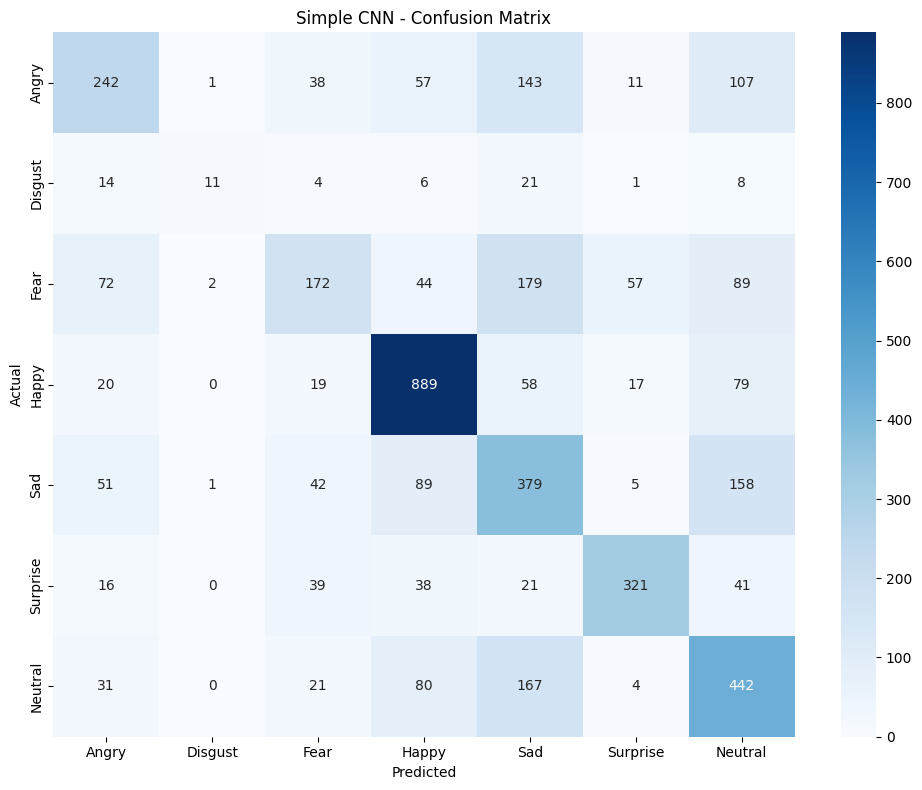

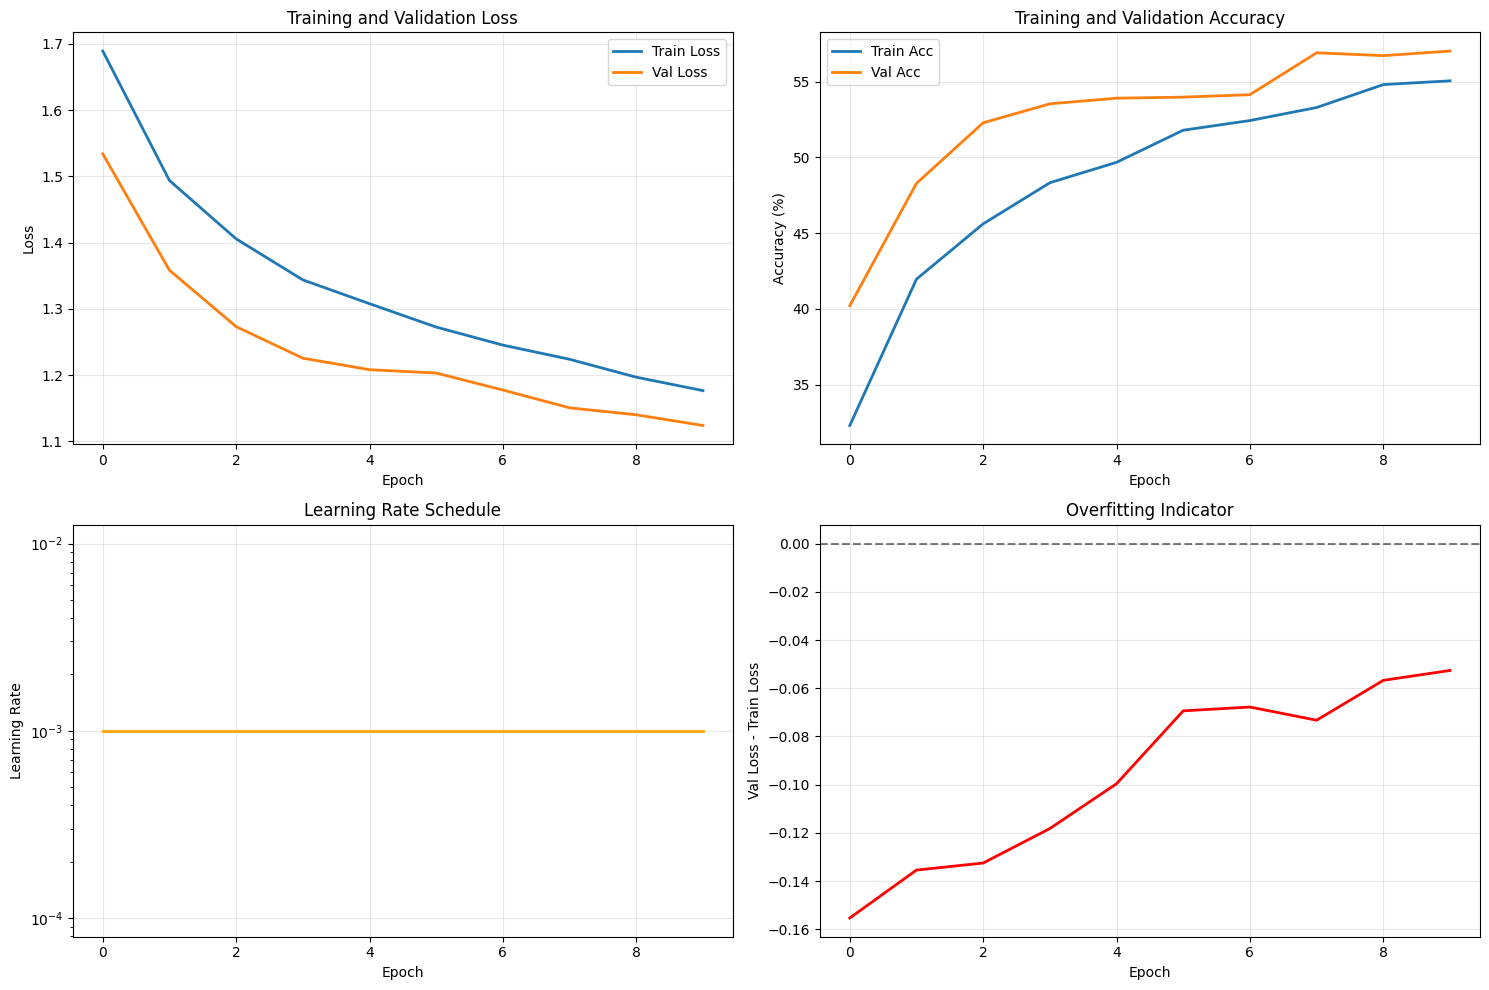

In [ ]:
print("=== SIMPLE CNN MODEL ANALYSIS ===")

final_model.eval()
all_predictions = []
all_targets = []
all_probabilities = []

with torch.no_grad():
    for data, targets in val_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = final_model(data)
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(outputs, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
all_probabilities = np.array(all_probabilities)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

accuracy = accuracy_score(all_targets, all_predictions)
precision, recall, f1, support = precision_recall_fscore_support(all_targets, all_predictions, average=None)

print(f"Final Validation Accuracy: {accuracy:.4f}")
print(f"Mean F1 Score: {np.mean(f1):.4f}")

class_names = [emotion_map[i] for i in range(7)]
report = classification_report(all_targets, all_predictions, target_names=class_names)
print("\nClassification Report:")
print(report)

cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Simple CNN - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('simple_cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(final_history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(final_history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(final_history['train_acc'], label='Train Acc', linewidth=2)
axes[0, 1].plot(final_history['val_acc'], label='Val Acc', linewidth=2)
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(final_history['learning_rates'], linewidth=2, color='orange')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

loss_gap = np.array(final_history['val_loss']) - np.array(final_history['train_loss'])
axes[1, 1].plot(loss_gap, linewidth=2, color='red')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Overfitting Indicator')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Val Loss - Train Loss')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('simple_cnn_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("=== SAVING SIMPLE CNN PIPELINE ===")

class SimpleCNNPipeline:

    def __init__(self, model_state_dict, model_config):
        self.model_config = model_config
        self.emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

        if model_config['model_type'] == 'improved':
            self.model = ImprovedSimpleCNN(**model_config['model_params'])
        else:
            self.model = SimpleCNN(num_classes=7, dropout_rate=0.3)

        self.model.load_state_dict(model_state_dict)
        self.model.eval()

        self.transform = A.Compose([
            A.Normalize(mean=[0.485], std=[0.229]),
            ToTensorV2()
        ])

    def preprocess(self, pixels_string):
        pixels = np.array([int(p) for p in pixels_string.split()]).reshape(48, 48)
        image = np.stack([pixels] * 3, axis=-1).astype(np.uint8)

        augmented = self.transform(image=image)
        image_tensor = augmented['image']

        if image_tensor.shape[0] == 3:
            image_tensor = image_tensor[0:1, :, :]

        return image_tensor.unsqueeze(0)

    def predict(self, pixels_string):
        with torch.no_grad():
            input_tensor = self.preprocess(pixels_string)
            output = self.model(input_tensor)
            probabilities = torch.softmax(output, dim=1)
            prediction = torch.argmax(output, dim=1)

            return {
                'predicted_class': int(prediction.item()),
                'predicted_emotion': self.emotion_map[int(prediction.item())],
                'confidence': float(probabilities.max().item()),
                'all_probabilities': {
                    self.emotion_map[i]: float(probabilities[0, i].item())
                    for i in range(7)
                }
            }

if isinstance(final_model, ImprovedSimpleCNN):
    model_type = 'improved'
    model_params = {
        'num_classes': 7,
        'dropout_rate': 0.3,
        'use_batch_norm': True
    }
else:
    model_type = 'simple'
    model_params = {
        'num_classes': 7,
        'dropout_rate': 0.3,
    }

model_config = {
    'model_type': model_type,
    'model_params': model_params
}

pipeline = SimpleCNNPipeline(final_model.state_dict(), model_config)


torch.save({
    'model_state_dict': final_model.state_dict(),
    'model_config': model_config,
    'training_history': final_history,
    'validation_accuracy': final_trainer.best_val_acc,
    'evaluation_metrics': {
        'accuracy': accuracy,
        'per_class_f1': f1.tolist(),
        'mean_f1': float(np.mean(f1)),
        'confusion_matrix': cm.tolist()
    },
    'experiment_results': {
        'augmentation_results': augmentation_results,
        'architecture_results': architecture_results,
        'config_results': config_results,
        'best_configuration': {
            'augmentation': best_augmentation,
            'architecture': best_architecture,
        },
        'best_configuration': {
            'augmentation': best_augmentation,
            'architecture': best_architecture,
            'config': best_config
        }
    }
}, 'models/saved_pipelines/simple_cnn_pipeline.pth')

print("✅ Simple CNN pipeline saved successfully!")

test_sample = val_df.iloc[0]['pixels']
test_prediction = pipeline.predict(test_sample)
print(f"\nPipeline test:")
print(f"Predicted emotion: {test_prediction['predicted_emotion']}")
print(f"Confidence: {test_prediction['confidence']:.4f}")

=== SAVING SIMPLE CNN PIPELINE ===
✅ Simple CNN pipeline saved successfully!

Pipeline test:
Predicted emotion: Sad
Confidence: 0.3698


In [13]:
print("=== TRAINING BEST SIMPLE CNN ===")

train_dataset = CNNFacialExpressionDataset(
    train_df, augment=True
)
val_dataset = CNNFacialExpressionDataset(
    val_df, augment=False
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
final_model = SimpleCNN(num_classes=7, dropout_rate=0.3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)

final_trainer = CNNTrainer(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_name="Simple_CNN_Training",
    run_name="Simple_CNN_Final"
)

final_history = final_trainer.train(epochs=50, early_stopping_patience=12)

wandb.finish()

print(f"✅ Final Simple CNN training completed!")
print(f"📊 Best validation accuracy: {final_trainer.best_val_acc:.4f}")

=== TRAINING BEST SIMPLE CNN ===


<ipython-input-5-e3e6e1c0bf17>:23: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=15, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=0),
<ipython-input-5-e3e6e1c0bf17>:25: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
<ipython-input-5-e3e6e1c0bf17>:27: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=8, max_width=8,
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Starting CNN training for 50 epochs...


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.37it/s]


Epoch 1/50:
  Train Loss: 1.7291, Train Acc: 30.58%
  Val Loss: 1.5856, Val Acc: 38.22%
  LR: 0.001000, Time: 14.77s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.26it/s]


Epoch 2/50:
  Train Loss: 1.5766, Train Acc: 38.29%
  Val Loss: 1.4114, Val Acc: 45.65%
  LR: 0.001000, Time: 13.04s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.80it/s]


Epoch 3/50:
  Train Loss: 1.4825, Train Acc: 42.38%
  Val Loss: 1.2960, Val Acc: 51.22%
  LR: 0.001000, Time: 12.97s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.10it/s]


Epoch 4/50:
  Train Loss: 1.4248, Train Acc: 44.86%
  Val Loss: 1.2583, Val Acc: 52.52%
  LR: 0.001000, Time: 13.20s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.37it/s]


Epoch 5/50:
  Train Loss: 1.3913, Train Acc: 46.26%
  Val Loss: 1.2409, Val Acc: 53.15%
  LR: 0.001000, Time: 12.98s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.85it/s]


Epoch 6/50:
  Train Loss: 1.3556, Train Acc: 47.89%
  Val Loss: 1.2122, Val Acc: 54.14%
  LR: 0.001000, Time: 13.09s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 39.14it/s]


Epoch 7/50:
  Train Loss: 1.3384, Train Acc: 48.40%
  Val Loss: 1.1772, Val Acc: 54.49%
  LR: 0.001000, Time: 13.12s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.12it/s]


Epoch 8/50:
  Train Loss: 1.3166, Train Acc: 49.43%
  Val Loss: 1.1595, Val Acc: 56.21%
  LR: 0.001000, Time: 13.15s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.85it/s]


Epoch 9/50:
  Train Loss: 1.3045, Train Acc: 49.69%
  Val Loss: 1.1496, Val Acc: 56.28%
  LR: 0.001000, Time: 13.14s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 39.27it/s]


Epoch 10/50:
  Train Loss: 1.2894, Train Acc: 50.78%
  Val Loss: 1.1151, Val Acc: 57.84%
  LR: 0.001000, Time: 13.14s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.40it/s]


Epoch 11/50:
  Train Loss: 1.2645, Train Acc: 51.70%
  Val Loss: 1.1238, Val Acc: 58.11%
  LR: 0.001000, Time: 13.08s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 39.37it/s]


Epoch 12/50:
  Train Loss: 1.2621, Train Acc: 51.17%
  Val Loss: 1.1400, Val Acc: 56.51%
  LR: 0.001000, Time: 13.02s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 39.24it/s]


Epoch 13/50:
  Train Loss: 1.2489, Train Acc: 52.35%
  Val Loss: 1.1231, Val Acc: 56.93%
  LR: 0.001000, Time: 13.00s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.86it/s]


Epoch 14/50:
  Train Loss: 1.2433, Train Acc: 52.24%
  Val Loss: 1.1435, Val Acc: 56.93%
  LR: 0.001000, Time: 13.24s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.86it/s]


Epoch 15/50:
  Train Loss: 1.2342, Train Acc: 52.88%
  Val Loss: 1.0968, Val Acc: 58.14%
  LR: 0.001000, Time: 12.99s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 39.16it/s]


Epoch 16/50:
  Train Loss: 1.2177, Train Acc: 53.31%
  Val Loss: 1.1022, Val Acc: 57.42%
  LR: 0.001000, Time: 12.96s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.87it/s]


Epoch 17/50:
  Train Loss: 1.2063, Train Acc: 53.77%
  Val Loss: 1.0941, Val Acc: 58.21%
  LR: 0.001000, Time: 13.20s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 39.47it/s]


Epoch 18/50:
  Train Loss: 1.2039, Train Acc: 54.18%
  Val Loss: 1.0870, Val Acc: 58.74%
  LR: 0.001000, Time: 12.98s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.14it/s]


Epoch 19/50:
  Train Loss: 1.1985, Train Acc: 54.49%
  Val Loss: 1.0970, Val Acc: 58.14%
  LR: 0.001000, Time: 13.13s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.75it/s]


Epoch 20/50:
  Train Loss: 1.1894, Train Acc: 54.48%
  Val Loss: 1.0881, Val Acc: 58.65%
  LR: 0.001000, Time: 13.00s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.73it/s]


Epoch 21/50:
  Train Loss: 1.1790, Train Acc: 54.77%
  Val Loss: 1.1051, Val Acc: 58.46%
  LR: 0.001000, Time: 13.17s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.35it/s]


Epoch 22/50:
  Train Loss: 1.1713, Train Acc: 55.19%
  Val Loss: 1.0961, Val Acc: 58.93%
  LR: 0.001000, Time: 13.18s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.98it/s]


Epoch 23/50:
  Train Loss: 1.1663, Train Acc: 55.32%
  Val Loss: 1.1033, Val Acc: 59.46%
  LR: 0.001000, Time: 13.11s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.76it/s]


Epoch 24/50:
  Train Loss: 1.1627, Train Acc: 55.66%
  Val Loss: 1.0819, Val Acc: 59.14%
  LR: 0.001000, Time: 13.18s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.78it/s]


Epoch 25/50:
  Train Loss: 1.1604, Train Acc: 55.62%
  Val Loss: 1.0728, Val Acc: 59.21%
  LR: 0.001000, Time: 13.13s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.69it/s]


Epoch 26/50:
  Train Loss: 1.1422, Train Acc: 56.28%
  Val Loss: 1.0920, Val Acc: 59.41%
  LR: 0.001000, Time: 13.33s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.78it/s]


Epoch 27/50:
  Train Loss: 1.1433, Train Acc: 56.09%
  Val Loss: 1.0827, Val Acc: 59.72%
  LR: 0.001000, Time: 13.04s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.18it/s]


Epoch 28/50:
  Train Loss: 1.1411, Train Acc: 56.69%
  Val Loss: 1.0938, Val Acc: 59.86%
  LR: 0.001000, Time: 13.13s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.63it/s]


Epoch 29/50:
  Train Loss: 1.1393, Train Acc: 56.53%
  Val Loss: 1.0685, Val Acc: 59.69%
  LR: 0.001000, Time: 12.99s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.02it/s]


Epoch 30/50:
  Train Loss: 1.1283, Train Acc: 57.12%
  Val Loss: 1.0675, Val Acc: 59.74%
  LR: 0.001000, Time: 13.10s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.34it/s]


Epoch 31/50:
  Train Loss: 1.1245, Train Acc: 57.00%
  Val Loss: 1.0766, Val Acc: 59.53%
  LR: 0.001000, Time: 13.08s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.43it/s]


Epoch 32/50:
  Train Loss: 1.1286, Train Acc: 56.76%
  Val Loss: 1.0721, Val Acc: 59.60%
  LR: 0.001000, Time: 13.15s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.44it/s]


Epoch 33/50:
  Train Loss: 1.1116, Train Acc: 57.63%
  Val Loss: 1.1050, Val Acc: 58.88%
  LR: 0.001000, Time: 13.18s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.29it/s]


Epoch 34/50:
  Train Loss: 1.1117, Train Acc: 57.19%
  Val Loss: 1.0944, Val Acc: 59.76%
  LR: 0.001000, Time: 13.17s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.37it/s]


Epoch 35/50:
  Train Loss: 1.1042, Train Acc: 57.83%
  Val Loss: 1.0745, Val Acc: 61.13%
  LR: 0.001000, Time: 13.20s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.43it/s]


Epoch 36/50:
  Train Loss: 1.0958, Train Acc: 58.09%
  Val Loss: 1.0972, Val Acc: 59.76%
  LR: 0.001000, Time: 13.14s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.06it/s]


Epoch 37/50:
  Train Loss: 1.0973, Train Acc: 58.56%
  Val Loss: 1.1279, Val Acc: 58.30%
  LR: 0.001000, Time: 13.37s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.21it/s]


Epoch 38/50:
  Train Loss: 1.0966, Train Acc: 58.27%
  Val Loss: 1.0946, Val Acc: 59.97%
  LR: 0.001000, Time: 13.27s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.28it/s]


Epoch 39/50:
  Train Loss: 1.0549, Train Acc: 59.86%
  Val Loss: 1.0630, Val Acc: 60.46%
  LR: 0.000500, Time: 13.12s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.82it/s]


Epoch 40/50:
  Train Loss: 1.0273, Train Acc: 61.27%
  Val Loss: 1.0802, Val Acc: 60.55%
  LR: 0.000500, Time: 13.19s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.60it/s]


Epoch 41/50:
  Train Loss: 1.0219, Train Acc: 61.20%
  Val Loss: 1.0912, Val Acc: 61.30%
  LR: 0.000500, Time: 13.33s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.04it/s]


Epoch 42/50:
  Train Loss: 1.0184, Train Acc: 61.66%
  Val Loss: 1.0903, Val Acc: 60.62%
  LR: 0.000500, Time: 13.22s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.21it/s]


Epoch 43/50:
  Train Loss: 1.0060, Train Acc: 61.96%
  Val Loss: 1.0916, Val Acc: 61.53%
  LR: 0.000500, Time: 13.23s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.34it/s]


Epoch 44/50:
  Train Loss: 0.9994, Train Acc: 62.46%
  Val Loss: 1.0835, Val Acc: 60.53%
  LR: 0.000500, Time: 13.19s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.45it/s]


Epoch 45/50:
  Train Loss: 1.0034, Train Acc: 61.97%
  Val Loss: 1.0912, Val Acc: 61.41%
  LR: 0.000500, Time: 13.17s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 38.62it/s]


Epoch 46/50:
  Train Loss: 0.9867, Train Acc: 62.94%
  Val Loss: 1.1038, Val Acc: 61.20%
  LR: 0.000500, Time: 13.21s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.16it/s]


Epoch 47/50:
  Train Loss: 0.9911, Train Acc: 62.61%
  Val Loss: 1.0679, Val Acc: 61.71%
  LR: 0.000500, Time: 13.23s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 37.40it/s]


Epoch 48/50:
  Train Loss: 0.9588, Train Acc: 63.75%
  Val Loss: 1.0893, Val Acc: 61.25%
  LR: 0.000250, Time: 13.37s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 36.91it/s]


Epoch 49/50:
  Train Loss: 0.9567, Train Acc: 63.63%
  Val Loss: 1.0742, Val Acc: 61.81%
  LR: 0.000250, Time: 13.21s
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:01<00:00, 35.78it/s]

Epoch 50/50:
  Train Loss: 0.9432, Train Acc: 64.33%
  Val Loss: 1.0759, Val Acc: 61.50%
  LR: 0.000250, Time: 13.58s
--------------------------------------------------
Loaded best model with validation accuracy: 61.81%


best_val_accuracy,▁▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch_time,█▁▁▂▁▂▂▂▂▁▁▂▁▁▂▂▁▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃
learning_rate,██████████████████████████████▃▃▃▃▃▃▃▃▁▁
train_accuracy,▁▃▃▄▄▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇██████
train_loss,█▇▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████
val_loss,█▆▄▄▃▃▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁
best_val_accuracy,61.80636
epoch,50
epoch_time,13.58139


✅ Final Simple CNN training completed!
📊 Best validation accuracy: 61.8064


🔍 Running inference on test set...


Test Evaluation: 100%|██████████| 135/135 [00:03<00:00, 41.14it/s]



🎯 FINAL TEST SET RESULTS
📈 Test Accuracy: 0.6155 (61.55%)
📊 Mean F1 Score: 0.5938
📊 Weighted F1 Score: 0.6154

📋 Per-Class Performance:
------------------------------------------------------------
Class        Precision  Recall     F1-Score   Support   
------------------------------------------------------------
Angry        0.512      0.524      0.518      599       
Disgust      0.824      0.431      0.566      65        
Fear         0.462      0.428      0.444      615       
Happy        0.825      0.841      0.833      1082      
Sad          0.502      0.506      0.504      725       
Surprise     0.777      0.704      0.739      476       
Neutral      0.525      0.583      0.553      745       

📊 Detailed Classification Report:
              precision    recall  f1-score   support

       Angry     0.5122    0.5242    0.5182       599
     Disgust     0.8235    0.4308    0.5657        65
        Fear     0.4622    0.4276    0.4443       615
       Happy     0.8250    0.8410

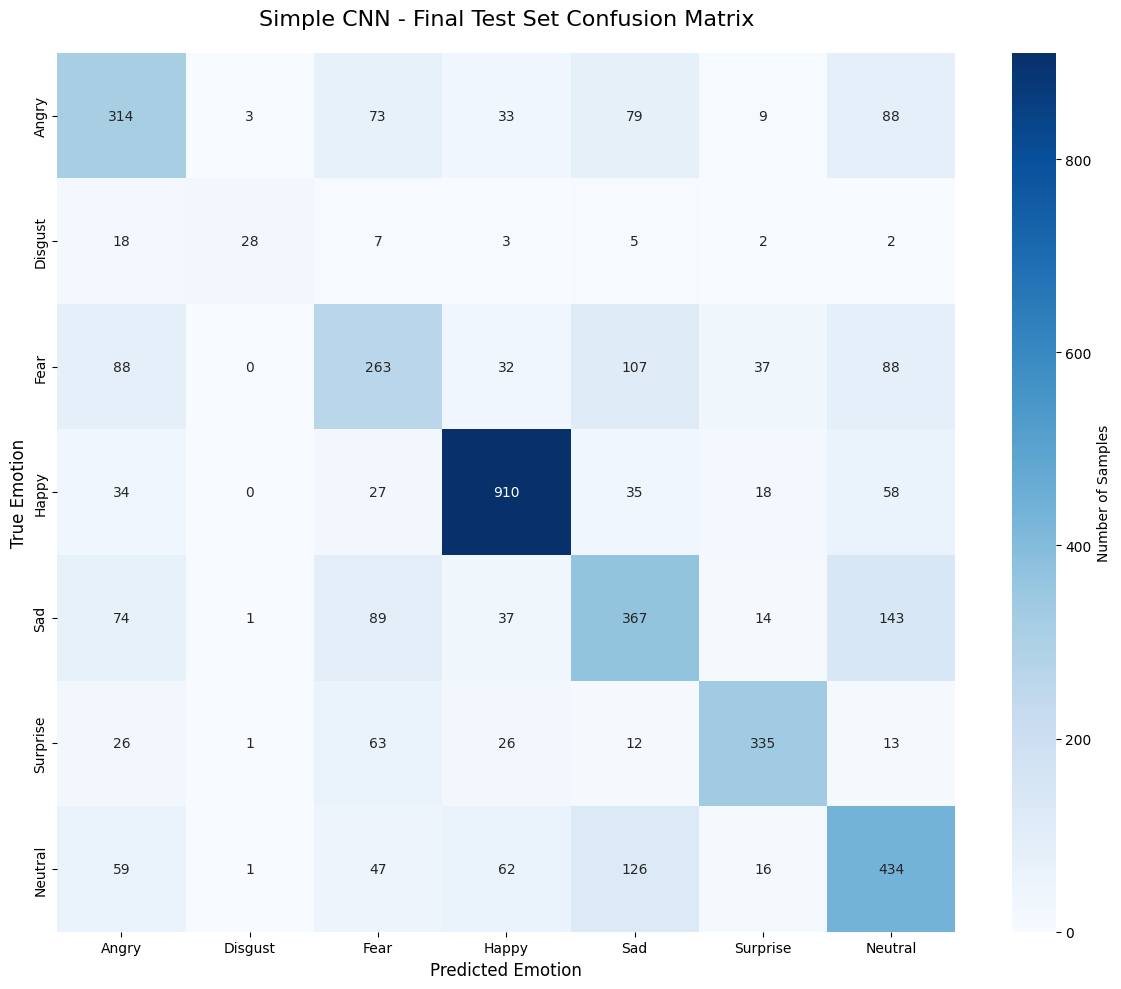


🎯 Per-Class Accuracy:
   Angry: 0.524 (52.4%)
   Disgust: 0.431 (43.1%)
   Fear: 0.428 (42.8%)
   Happy: 0.841 (84.1%)
   Sad: 0.506 (50.6%)
   Surprise: 0.704 (70.4%)
   Neutral: 0.583 (58.3%)

🎯 ROC-AUC Scores:
   Angry: 0.8617
   Disgust: 0.9553
   Fear: 0.8189
   Happy: 0.9584
   Sad: 0.8541
   Surprise: 0.9483
   Neutral: 0.8693
   Mean AUC: 0.8951

🔍 Generalization Analysis:
   Best Validation Accuracy: 61.81%
   Test Accuracy: 61.55%
   Generalization Gap: 0.26%
   ✅ Excellent generalization - test performance matches validation


In [20]:
test_dataset = CNNFacialExpressionDataset(test_df, augment=False, is_test=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


clean_model = SimpleCNN(num_classes=7, dropout_rate=0.3)
clean_model.load_state_dict(final_model.state_dict())
clean_model.to(device)
clean_model.eval()

print("🔍 Running inference on test set...")
all_test_predictions = []
all_test_targets = []
all_test_probabilities = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Test Evaluation"):
        data, targets = data.to(device), targets.to(device)
        outputs = clean_model(data)
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(outputs, dim=1)

        all_test_predictions.extend(predictions.cpu().numpy())
        all_test_targets.extend(targets.cpu().numpy())
        all_test_probabilities.extend(probabilities.cpu().numpy())

all_test_predictions = np.array(all_test_predictions)
all_test_targets = np.array(all_test_targets)
all_test_probabilities = np.array(all_test_probabilities)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize

test_accuracy = accuracy_score(all_test_targets, all_test_predictions)
test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(
    all_test_targets, all_test_predictions, average=None
)

print("\n" + "="*60)
print("🎯 FINAL TEST SET RESULTS")
print("="*60)
print(f"📈 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📊 Mean F1 Score: {np.mean(test_f1):.4f}")
print(f"📊 Weighted F1 Score: {np.average(test_f1, weights=test_support):.4f}")

emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
class_names = [emotion_map[i] for i in range(7)]

print(f"\n📋 Per-Class Performance:")
print("-" * 60)
print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 60)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<12} {test_precision[i]:<10.3f} {test_recall[i]:<10.3f} {test_f1[i]:<10.3f} {test_support[i]:<10}")

report = classification_report(all_test_targets, all_test_predictions,
                             target_names=class_names, digits=4)
print(f"\n📊 Detailed Classification Report:")
print(report)

cm = confusion_matrix(all_test_targets, all_test_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names,
           cbar_kws={'label': 'Number of Samples'})
plt.title('Simple CNN - Final Test Set Confusion Matrix', fontsize=16, pad=20)
plt.xlabel('Predicted Emotion', fontsize=12)
plt.ylabel('True Emotion', fontsize=12)
plt.tight_layout()
plt.savefig('simple_cnn_final_test_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

class_accuracies = cm.diagonal() / cm.sum(axis=1)
print(f"\n🎯 Per-Class Accuracy:")
for i, (class_name, acc) in enumerate(zip(class_names, class_accuracies)):
    print(f"   {class_name}: {acc:.3f} ({acc*100:.1f}%)")

try:
    targets_binary = label_binarize(all_test_targets, classes=range(7))
    auc_scores = []
    print(f"\n🎯 ROC-AUC Scores:")
    for i in range(7):
        if len(np.unique(targets_binary[:, i])) > 1:
            auc = roc_auc_score(targets_binary[:, i], all_test_probabilities[:, i])
            auc_scores.append(auc)
            print(f"   {class_names[i]}: {auc:.4f}")
    print(f"   Mean AUC: {np.mean(auc_scores):.4f}")
except Exception as e:
    print(f"⚠️  Could not compute ROC-AUC: {e}")

print(f"\n🔍 Generalization Analysis:")
print(f"   Best Validation Accuracy: {final_trainer.best_val_acc:.2f}%")
print(f"   Test Accuracy: {test_accuracy*100:.2f}%")
generalization_gap = final_trainer.best_val_acc - (test_accuracy*100)
print(f"   Generalization Gap: {generalization_gap:.2f}%")

if abs(generalization_gap) < 2:
    print("   ✅ Excellent generalization - test performance matches validation")
elif abs(generalization_gap) < 5:
    print("   ✅ Good generalization - small performance drop")
elif generalization_gap > 5:
    print("   ⚠️  Model may be slightly overfitted to validation set")
else:
    print("   🎉 Model performed better on test set than validation!")